In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError
from scipy.stats import pearsonr, spearmanr
import csv
import mne

from fooof import FOOOF, FOOOFGroup
from fooof.analysis import *
from fooof.synth import *

from ratios import *

In [2]:
# Open CSV
data = pd.read_csv("../dat/MIPDB_PublicFile.csv")

In [3]:
# Read in list of channel names that are kept in reduced 111 montage
with open('../dat/chans111.csv', 'r') as csv_file:
    reader = csv.reader(csv_file)
    ch_labels = list(reader)[0]
    
# Read montage, reduced to 111 channel selection
montage = mne.channels.read_montage('GSN-HydroCel-129', ch_names=ch_labels)

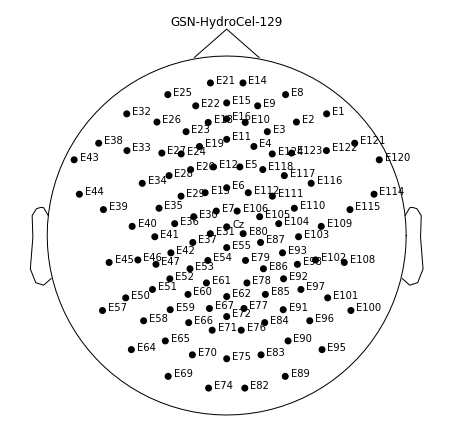

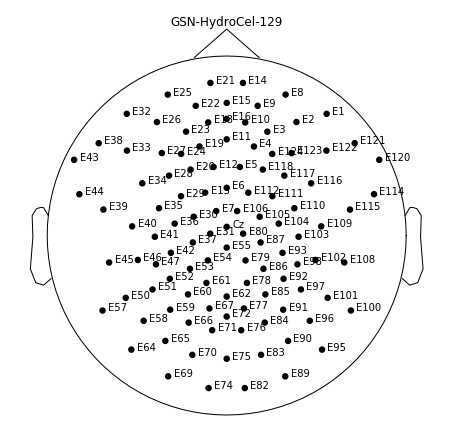

In [34]:
montage.plot()

In [35]:
# Define a channel cluster of interest
ch_cluster_parietal = ['E71', 'E76', 'E70', 'E75', 'E83']
ch_cluster_central = ['E7','E106', 'E31', 'Cz', 'E80']
ch_cluster_frontal = ['E15', 'E18', 'E16', 'E10', 'E11']

# Get the indices of the channels of interest
ch_inds_parietal = mne.pick_channels(montage.ch_names, ch_cluster_parietal)
ch_inds_central = mne.pick_channels(montage.ch_names, ch_cluster_central)
ch_inds_frontal = mne.pick_channels(montage.ch_names, ch_cluster_frontal)

In [37]:
def get_real_params(df, chs, age=[0,100]):


	age_range = df[(df['Age'] >= age[0]) & (df['Age'] <= age[1])]
	age_range_ids = age_range.ID.values
	#Open Eyes closed data for all IDs
	problem_files = []
	missing_files = []
	peaks = []
	apcs = []
	tb_ratios = []

	for filename in age_range_ids:
	    try:
	        # Construct FOOOFGroup model on psd
	        curr = np.load('../dat/psds/'+ filename + '_ec_psds.npz')
	        freqs = curr['arr_0']
	        for ch in chs:
	            
	            ps = curr['arr_1'][0][ch]
	            fm = FOOOF(verbose=False)
	            fm.add_data(freqs, ps)
	            fm.fit()
	            
	            # Following ratio is only for one block
	            curr_ratio = calc_band_ratio(freqs, ps, THETA_BAND, BETA_BAND)
	            tb_ratios.append(curr_ratio)
	            
	            # Append params to respective array
	            apcs.append(fm.aperiodic_params_[1])
	            peaks.append(fm.peak_params_)
	        
	    except FileNotFoundError:
	        missing_files.append(filename)
	    except ValueError:
	        problem_files.append(filename)
	    except LinAlgError:
	        problem_files.append(filename)

	return [tb_ratios, apcs, peaks], [problem_files, missing_files]

In [38]:
all_age_parietal = get_real_params(data, ch_inds_parietal)
all_age_central = get_real_params(data, ch_inds_central)
all_age_frontal = get_real_params(data, ch_inds_frontal)

In [39]:
all_age_parietal_tb_ratio = all_age_parietal[0][0]
all_age_parietal_apc = all_age_parietal[0][1]

all_age_central_tb_ratio = all_age_central[0][0]
all_age_central_apc = all_age_central[0][1]

all_age_frontal_tb_ratio = all_age_frontal[0][0]
all_age_frontal_apc = all_age_frontal[0][1]

In [41]:
all_age_parietal_pearson = pearsonr(all_age_parietal_apc, all_age_parietal_tb_ratio)
all_age_parietal_spearman = spearmanr(all_age_parietal_apc, all_age_parietal_tb_ratio)

all_age_central_pearson = pearsonr(all_age_central_apc, all_age_central_tb_ratio)
all_age_central_spearman = spearmanr(all_age_central_apc, all_age_central_tb_ratio)

all_age_frontal_pearson = pearsonr(all_age_frontal_apc, all_age_frontal_tb_ratio)
all_age_frontal_spearman = spearmanr(all_age_frontal_apc, all_age_frontal_tb_ratio)

print("All subjects parietal pearson: ", all_age_parietal_pearson)
print("All subjects parietal spearman: ", all_age_parietal_spearman)
print(" ")

print("All subjects central pearson: ", all_age_central_pearson)
print("All subjects central spearman: ", all_age_central_spearman)
print(" ")

print("All subjects frontal pearson: ", all_age_frontal_pearson)
print("All subjects frontal spearman: ", all_age_frontal_spearman)
print(" ")

All subjects parietal pearson:  (0.6933802935375113, 9.460974884081897e-71)
All subjects parietal spearman:  SpearmanrResult(correlation=0.7657818421642227, pvalue=1.1848669410488807e-94)
 
All subjects central pearson:  (0.7047344054232837, 5.15602101678039e-74)
All subjects central spearman:  SpearmanrResult(correlation=0.8077568352482442, pvalue=6.328379262281096e-113)
 
All subjects frontal pearson:  (0.6557619543093932, 6.042626433221246e-61)
All subjects frontal spearman:  SpearmanrResult(correlation=0.7418850590671897, pvalue=7.043018118008337e-86)
 


## Young Age

This section calculates band ratios and the power exponent and determines the correlation between the two.

In [6]:
young = data[(data['Age'] >= 10) & (data['Age'] <= 13)]

#Extract ID's to open their corresponding files
young_IDs = young.ID.values

In [7]:
# FOOOF Settings
peak_width_limits = (1, 6) 

In [8]:
#Open Eyes closed data for all IDs
problem_files = []
missing_files = []
young_peaks = []
young_apcs = []
young_tb_ratios = []

for filename in young_IDs:
    try:
        # Construct FOOOFGroup model on psd
        curr = np.load('../dat/psds/'+ filename + '_ec_psds.npz')
        freqs = curr['arr_0']
        for ch in ch_inds:
            
            ps = curr['arr_1'][0][ch]
            fm = FOOOF(verbose=False)
            fm.add_data(freqs, ps)
            fm.fit()
            
            # Following ratio is only for one block
            curr_ratio = calc_band_ratio(freqs, ps, THETA_BAND, BETA_BAND)
            young_tb_ratios.append(curr_ratio)
            
            # Append params to respective array
            young_apcs.append(fm.aperiodic_params_[1])
            # young_peaks.append(fg.get_all_data('peak_params'))
        
    except FileNotFoundError:
        missing_files.append(filename)
    except ValueError:
        problem_files.append(filename)
    except LinAlgError:
        problem_files.append(filename)

In [9]:
fm.peak_params_

array([[ 9.84724795,  1.48219477,  3.00179298],
       [15.16285634,  0.34809455,  1.81360541],
       [17.44272081,  0.48291383,  0.5       ],
       [19.11775004,  0.35100811,  2.67710974]])

In [9]:
young_spear = spearmanr(young_apcs, young_tb_ratios)
young_pear = pearsonr(young_apcs, young_tb_ratios)

In [11]:
print("Spearman Avg: ", young_spear)
print("Pearson Avg: ", young_pear)

Spearman Avg:  SpearmanrResult(correlation=0.6078219752624691, pvalue=4.8339223862579e-18)
Pearson Avg:  (0.5613354755664276, 4.407109509583849e-15)


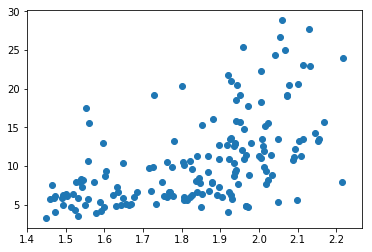

In [14]:
plt.scatter(young_apcs, young_tb_ratios)


## Old Age

In [15]:
old = data[(data['Age'] >= 25)]

#Extract ID's to open their corresponding files
old_IDs = old.ID.values

#Open Eyes closed data for all IDs
problem_files_old = []
missing_files_old = []
old_apcs = []
old_tb_ratios = []

for filename in old_IDs:
    try:
        curr = np.load('../dat/psds/'+ filename + '_ec_psds.npz')
        freqs = curr['arr_0']
        for ch in ch_inds:
            
            ps = curr['arr_1'][0][ch]
        
            fm = FOOOF(verbose=False)
            fm.add_data(freqs, ps)
            fm.fit()
        
            # Following ratio is only for one block
            curr_ratio = calc_band_ratio(curr['arr_0'], curr['arr_1'][0], THETA_BAND, BETA_BAND)
            old_tb_ratios.append(curr_ratio)
            old_apcs.append(fm.aperiodic_params_[1])
        
            #old_params.append(fm.peak_params_[])
        
    except FileNotFoundError:
        missing_files_old.append(filename)
    except ValueError:
        problem_files_old.append(filename)
    except LinAlgError:
        problem_files_old.append(filename)

In [16]:
old_spear = spearmanr(old_apcs, old_tb_ratios)
old_pear = pearsonr(old_apcs, old_tb_ratios)

In [17]:
print("Old Spearman Avg: ", old_spear)
print("Old Pearson Avg: ", old_pear)

Old Spearman Avg:  SpearmanrResult(correlation=0.6280383056320723, pvalue=2.855498854069624e-07)
Old Pearson Avg:  (0.7093579858038961, 1.3442347746480015e-09)


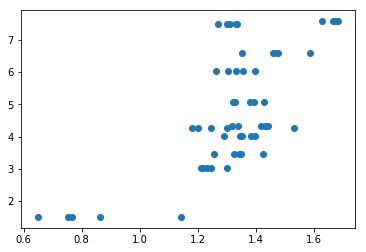

In [18]:
plt.scatter(old_apcs, old_tb_ratios, c=)


In [14]:
old_master = []
for i in range(0,7,2):
    bgs = old_params[i].tolist()
    gausses = old_params[i+1].tolist()
    
    bgs_df = pd.DataFrame({"Background" : bgs})
    gausses_df = pd.DataFrame({"Gaussians" : gausses})
    
    cur = [bgs_df, gausses_df]
    old_master.append(cur)

## Differences in BG params  

In [155]:
#young_master
y_bg_1 = 0
y_bg_2 = 0
count = 0

for i in young_master:
    y_bg_1 += i[0].values[0][0][0]
    y_bg_2 += i[0].values[0][0][1]
    count+=1
young_bg_1 = y_bg_1/(count+1)
young_bg_2 = y_bg_2/(count+1)

young_bg = [young_bg_1,young_bg_2]

In [156]:
o_bg_1 = 0
o_bg_2 = 0
count = 0

for i in old_master:
    o_bg_1 += i[0].values[0][0][0]
    o_bg_2 += i[0].values[0][0][1]
    count+=1
old_bg_1 = o_bg_1/(count+1)
old_bg_2 = o_bg_2/(count+1)

old_bg = [old_bg_1,old_bg_2]

In [164]:
print("background param 1 difference:",abs(old_bg[0] - young_bg[0]))
print("background param 2 difference:",abs(old_bg[1] - young_bg[1]))

background param 1 difference: 0.8852820763497281
background param 2 difference: 0.7435350192201011


## Differences in BandRatio Measures

In [20]:
diff_tb_ratio = np.abs(np.mean(young_tb_ratios) - np.mean(old_tb_ratios))
print("Average young Theta/Beta:", np.mean(young_tb_ratios))
print("Average old Theta/Beta:", np.mean(old_tb_ratios))
print("Difference in average Theta/Beta ratio", diff_tb_ratio)

Average young Theta/Beta: 8.189531639873604
Average old Theta/Beta: 4.1547301345251855
Difference in average Theta/Beta ratio 4.034801505348418
